<a target="_blank" href="https://colab.research.google.com/github/Prindle19/sdsc24/blob/main/01%20-%20EE%20Python%20Intro.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction

This notebook walks through the process of creating a PDF-format report for a given land plot. It shows the location of the plot and various spectral history figures that illustrate what is in the plot and how the plot changes seasonally and over 40 years. It uses Google Earth Engine along with many 3rd party Python libraries.

If you need to get set up to use Earth Engine or are unfamiliar with running Earth Engine in a Colab notebook, use the [**Earth Engine Python Quickstart**](https://developers.google.com/earth-engine/guides/quickstart_python) to get going.

_Presented at the 2024 Google Geo for Good Sao Paulo and Dublin meetings._

# Setup

Intall packages we need that Colab doesn't have installed by defualt.

In [ ]:
!pip install -q reportlab
!pip install -q -U pillow
!pip install -q cartopy
!pip install -q PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.5 MB/s eta 0:00:00


Import the libraries we'll need.

In [ ]:
import os
import io
import ee
import geemap
import glob
import requests
import json
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import numpy as np
import matplotlib
import PyPDF2

from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt
from matplotlib import cm
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.utils import ImageReader

Authenticate and initialize to the Earth Engine service.

CHANGE THE PROJECT TO YOURS.

In [ ]:
ee.Authenticate()
ee.Initialize(project='ee-braaten') # CHANGE TO YOURS

# Find a point of interest

Create a `geemap.Map` object and display it. Use it to identify a point to create a report for.

In [ ]:
m = geemap.Map()
m.add_basemap('SATELLITE')
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Create a region of interest. Define the longitude and latitude of the selected location and define a buffer to add to the point.

In [ ]:
lon = -123.6
lat = 48
buffer = 250 # meters
ee_region = ee.Geometry.Point(lon, lat).buffer(buffer)
m.add_layer(ee_region, {'color': 'yellow'}, 'ROI')

# Set global and final output variables

Create some folders on the Colab VM and set some file names.

In [ ]:
folder_figures = '/content/figures'
folder_monthly_images = '/content/monthly_images'
folder_annual_images = '/content/annual_images'
folder_pdfs = '/content/pdfs'
folders = [folder_figures, folder_monthly_images, folder_annual_images, folder_pdfs]

small_scale_map = f'{folder_figures}/small_scale_map.png'
large_scale_map = f'{folder_figures}/large_scale_map.png'
single_year = f'{folder_figures}/landsat_large.png'

monthly_nbr = f'{folder_figures}/monthly_nbr.png'
annual_nbr = f'{folder_figures}/annual_nbr.png'

pdf_1 = f'{folder_pdfs}/page_1.pdf'
pdf_2 = f'{folder_pdfs}/page_2.pdf'
pdf_3 = f'{folder_pdfs}/page_3.pdf'
pdf_full = f'{folder_pdfs}/plot_report.pdf'

annual_col = ee.ImageCollection('LANDSAT/COMPOSITES/C02/T1_L2_ANNUAL')
monthly_col = ee.ImageCollection('LANDSAT/COMPOSITES/C02/T1_L2_32DAY')

for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Make location figures

Create a small-scale map of the location.

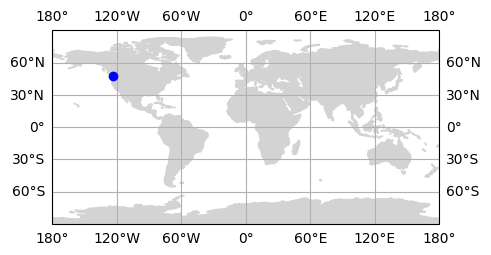

In [ ]:
plt.figure(figsize=(5, 2.7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, color='lightgrey', zorder=0)
ax.gridlines(draw_labels=True, zorder=1)
ax.scatter(lon, lat, color='blue', zorder=2)
ax.set_global()

plt.savefig(small_scale_map, bbox_inches='tight')
plt.show()

Create a medium-scale map of the location.

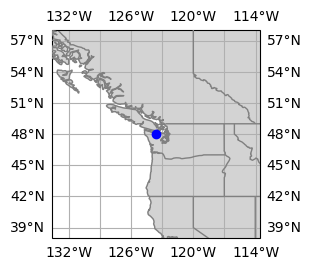

In [ ]:
gpd_region = ee.data.computeFeatures({
    'expression': ee.FeatureCollection([ee.Feature(ee_region.bounds())]),
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
buffered_geom = gpd_region.buffer(10)
bounds = buffered_geom.bounds

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

plt.figure(figsize=(2.7, 2.7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, color='lightgrey', zorder=0)
ax.gridlines(draw_labels=True, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', zorder=2)
ax.add_feature(cfeature.COASTLINE, edgecolor='gray', zorder=3)
ax.add_feature(states_provinces, edgecolor='gray', zorder=4)
ax.scatter(lon, lat, color='blue', zorder=5)
ax.set_extent(
    [bounds['minx'], bounds['maxx'], bounds['miny'], bounds['maxy']],
    crs=ccrs.PlateCarree())
plt.savefig(large_scale_map, bbox_inches='tight')
plt.show()

Define a function to fetch Landsat image chips.

In [ ]:
def prepare_image(image, region_geom, buffer, dim, width, filename):
    '''Makes a visualization image clipped to a region with a plot overlay.'''
    region_geom = ee.Geometry(region_geom)
    region_extract = region_geom.buffer(buffer).bounds()
    region_fc = ee.FeatureCollection(ee.Feature(region_geom))
    region_image = ee.Image().paint(region_fc, width=width).visualize(palette=['FFFFFF'])

    vis = {
        'bands': ['swir1', 'nir', 'green'],
        'min': 0,
        'max': 0.4
    }
    vis_image = (image.visualize(**vis)
        .reproject('EPSG:4326', None, 30)
        .resample('bicubic')
        .blend(region_image)
        .clipToBoundsAndScale(geometry=region_extract, width=dim, height=dim))
    return vis_image

def get_png(image):
    '''Makes a computePixels request from a given image.'''
    return ee.data.computePixels({
        'expression': image,
        'fileFormat': 'PNG'
    })

def save_png(request, filename):
    '''Saves the returned computePixels request to disk.'''
    image = Image.open(io.BytesIO(request))
    image.save(filename)
    return None

def process_image(image, region_geom, buffer, dim, width, filename):
    '''Wraps functions to get an save an image chip for a region.'''
    vis_image = prepare_image(image, region_geom, buffer, dim, width, filename)
    png = get_png(vis_image)
    save_png(png, filename)
    return None

Get an image for the region of interest – last year's annual median.

In [ ]:
current_year = datetime.datetime.now().year

last_year_landsat_mean = (annual_col.filterBounds(ee_region)
    .filterDate(str(current_year - 1), str(current_year))).first()

last_year_landsat_mean

Request the image as a PNG image chip to include in the report.

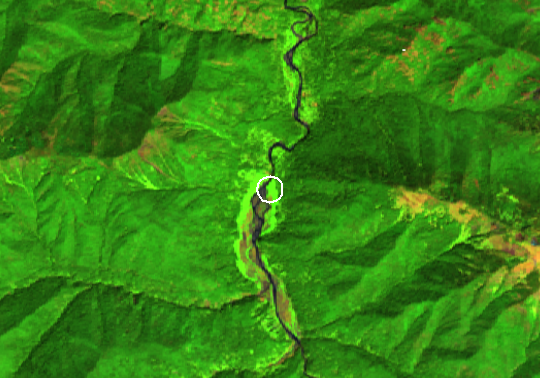

In [ ]:
process_image(last_year_landsat_mean, ee_region, 5000, 540, 2, single_year)

with Image.open(single_year) as image:
    width, height = image.size
    top = height * 0.15
    bottom = height * 0.85
    cropped_image = image.crop((0, top, width, bottom))
    display(cropped_image)
    cropped_image.save(single_year)

Create a PDF canvas and add text and the location figures to it.

In [ ]:
width, height = letter
page_margin = 0.5 * inch

c = canvas.Canvas(pdf_1, pagesize=letter)

c.setFont('Helvetica-Bold', 16)
c.drawString(page_margin, 740, 'Important Ecological Project')

c.setFont('Helvetica-Bold', 14)
c.drawString(page_margin, 720, 'Region 1')

c.setFont('Helvetica', 12)
c.drawString(page_margin, 690, 'A short description about this marvelous plot.')

c.setFont('Helvetica-Bold', 14)
c.drawString(page_margin, 640, 'Location')

c.drawImage(small_scale_map, page_margin, 450, 320, 173)
c.drawImage(large_scale_map, page_margin + 340, 450, 200, 173)
c.drawImage(single_year, page_margin, page_margin)

c.save()

# Get intra-annual time series

Get a collections of 32-day Landsat composites for the previous year and save image chips for the region of interest.

In [ ]:
#!rm {folder_monthly_images}/*.png

img_col = (monthly_col.filterBounds(ee_region)
    .filterDate(str(current_year-1), str(current_year)))

img_list = img_col.toList(img_col.size())

for i in range(img_col.size().getInfo()):
    img = ee.Image(img_list.get(i))
    date = img.date().format('YYYY-MM-dd').getInfo()
    print(f'Processing: {date}')
    process_image(img, ee_region, 1500, 256, 2, f'{folder_monthly_images}/img_{date}.png')

Processing: 2023-01-01
Processing: 2023-02-02
Processing: 2023-03-06
Processing: 2023-04-07
Processing: 2023-05-09
Processing: 2023-06-10
Processing: 2023-07-12
Processing: 2023-08-13
Processing: 2023-09-14
Processing: 2023-10-16
Processing: 2023-11-17
Processing: 2023-12-19


Display a representative image chip.

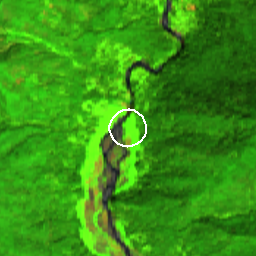

In [ ]:
monthly_image_files = sorted(glob.glob(f'{folder_monthly_images}/*.png'))

with Image.open(monthly_image_files[6]) as image:
    display(image)

Start the second page of the report. It starts with the 32-day image chips.

In [ ]:
width, height = letter
page_margin = 0.5 * inch

image_margin_x = 0.11 * inch
image_margin_y = 0.25 * inch

max_image_width = 1.77 * inch
max_image_height = 1.77 * inch
x_offset = page_margin
y_offset = height - page_margin - 0.75 * inch  # Reduced initial spacing

# Create a new PDF canvas
c = canvas.Canvas(pdf_2, pagesize=letter)

c.setFont('Helvetica-Bold', 14)
c.drawString(page_margin, 740, 'Monthly spectral history for previous year and 10-year comparison')
c.setFont('Helvetica', 10)

# Function to add an image to the canvas and wrap if necessary
def add_image(image_path):
    global x_offset, y_offset

    # Open the image using Pillow
    img = Image.open(image_path)

    # Resize image while preserving aspect ratio
    img.thumbnail((max_image_width, max_image_height))
    image_width, image_height = img.size

    # Check if the image and label fit on the current page
    if x_offset + image_width + image_margin_x + page_margin > width:
        x_offset = page_margin
        y_offset -= max_image_height + image_margin_y + 0.15 * inch  # Reduced spacing

    if y_offset - image_height - 0.15 * inch - page_margin < 0:
        c.showPage()
        x_offset = page_margin
        y_offset = height - page_margin - 0.15 * inch

    # Add label above the image
    c.drawString(
        x_offset, y_offset, os.path.basename(image_path).replace('img_', '').replace('.png', ''))

    # Draw the image on the canvas
    c.drawImage(image_path, x_offset, y_offset - image_height - 0.15*inch, image_width, image_height)

    # Update x_offset for the next image
    x_offset += image_width + image_margin_x


for image_path in monthly_image_files:
  add_image(image_path)


Get a DataFrame that includes information to generate an inter-annual time series chart for the previous 11 years.

In [ ]:
def get_region_mean(region):
    '''Returns a function to compute the mean of a region.'''
    def region_mean(img):
        '''Computes the mean of a region.'''
        region_stats = img.reduceRegion(
            geometry=region, reducer=ee.Reducer.mean(), scale=30)
        return ee.Feature(None, region_stats).set(
            {'month': img.date().get('month'), 'year': img.date().get('year')})
    return region_mean

img_col = (monthly_col.filterBounds(ee_region)
    .filterDate(str(current_year-11), str(current_year)))

monthly_images = img_col.map(get_region_mean(ee_region))

df = ee.data.computeFeatures(
    {'expression': monthly_images, 'fileFormat': 'PANDAS_DATAFRAME'})

df['nbr'] = (df['nir'] - df['swir1']) / (df['nir'] + df['swir1'])
df

,geo,month,year,blue,green,nir,red,swir1,swir2,thermal,nbr
0,None,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,2,2013,0.041393,0.043696,0.079719,0.046078,0.074614,0.052252,279.943188,0.033081
2,None,3,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,4,2013,0.075392,0.089881,0.126831,0.093014,0.121413,0.101561,302.105786,0.021823
4,None,5,2013,0.058294,0.072907,0.174089,0.073435,0.143568,0.102025,296.020039,0.096084
...,...,...,...,...,...,...,...,...,...,...,...
127,None,8,2023,0.029240,0.047055,0.286740,0.038591,0.127841,0.062178,303.029711,0.383275
128,None,9,2023,0.024388,0.042772,0.240322,0.037153,0.117889,0.059274,294.090741,0.341790
129,None,10,2023,0.022828,0.039800,0.203135,0.035990,0.110507,0.057447,280.817670,0.295331
130,None,11,2023,0.013328,0.026099,0.150334,0.028657,0.082175,0.043111,275.205810,0.293144


Make a chart from the 11-year inter-annual time series DataFrame.

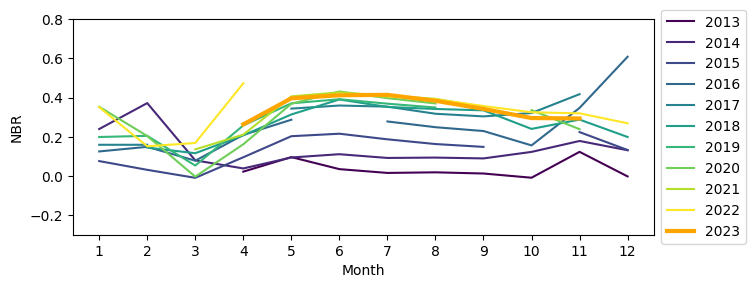

In [ ]:
plot_width = width - 2 * page_margin
plot_height = height - 2 * page_margin

plot_height = 2.8
fig, ax = plt.subplots(figsize=(plot_width / inch, plot_height))

viridis = cm.get_cmap('viridis', 10)
colors = viridis(np.linspace(0, 1, 10))
hex_colors = [matplotlib.colors.rgb2hex(color) for color in colors]

for i, year in enumerate(df['year'].unique()):
    df_subset = df[df['year'] == year]
    if i == len(df['year'].unique()) -1:
        ax.plot(df_subset['month'], df_subset['nbr'], label=year, color='orange', linewidth=3)
    else:
        ax.plot(df_subset['month'], df_subset['nbr'], label=year, color=hex_colors[i])

ax.set_ylim(-0.3, 0.8)
ax.set_xlabel('Month')
ax.set_ylabel('NBR')
ax.set_title('')
ax.set_xticks(df['month'].unique())
ax.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(monthly_nbr, bbox_inches='tight')
plt.show()

Add the chart to the 2nd page of the PDF report.

In [ ]:
c.drawImage(monthly_nbr, page_margin, page_margin, plot_width, 200)
c.save()

# Get annual time series

Get a collection of annual Landsat composites for the previous year and get the DataFrame of the regional mean for each image.

In [ ]:
img_col = (annual_col.filterBounds(ee_region)
    .filterDate('1984-01-01', f'{str(current_year)}-01-01'))

annual_images = img_col.map(get_region_mean(ee_region))

df = ee.data.computeFeatures(
    {'expression': annual_images, 'fileFormat': 'PANDAS_DATAFRAME'})

df['nbr'] = (df['nir'] - df['swir1']) / (df['nir'] + df['swir1'])
df

,geo,blue,green,month,nir,red,swir1,swir2,thermal,year,nbr
0,None,0.045801,0.053537,1,0.079738,0.035626,0.034737,0.021043,285.592428,1984,0.393107
1,None,0.035366,0.041808,1,0.057636,0.027509,0.021121,0.012191,283.067867,1985,0.463640
2,None,0.036727,0.047035,1,0.053211,0.032098,0.019556,0.011281,284.150365,1986,0.462500
3,None,0.035180,0.041717,1,0.058676,0.023000,0.021786,0.011933,285.307437,1987,0.458484
4,None,0.031876,0.037253,1,0.050535,0.019658,0.018437,0.009643,287.458514,1988,0.465384
5,None,0.038212,0.049194,1,0.061087,0.030222,0.021360,0.012052,284.823094,1989,0.481846
6,None,0.027831,0.032687,1,0.049495,0.018023,0.017720,0.009295,286.335399,1990,0.472724
7,None,0.038554,0.047651,1,0.056503,0.026905,0.020516,0.011103,286.139978,1991,0.467242
8,None,0.048214,0.058518,1,0.089337,0.044777,0.032575,0.016686,284.358271,1992,0.465597
9,None,0.034004,0.039894,1,0.058172,0.025347,0.020572,0.011221,286.312347,1993,0.477498


Create a time series chart from the annual time series DataFrame.

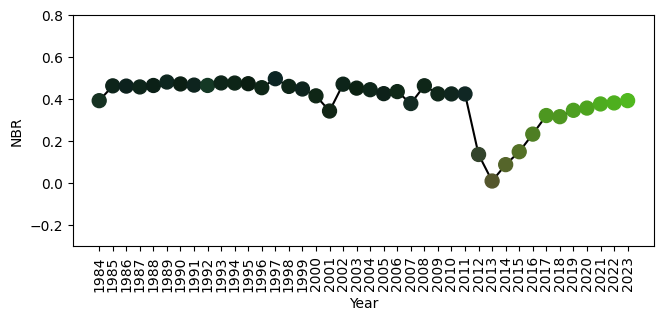

In [ ]:
df['r'] = df['swir1'] * (255 / 0.4)
df['g'] = df['nir'] * (255 / 0.4)
df['b'] = df['green'] * (255 / 0.4)
rgb_values = df[['r', 'g', 'b']].values.astype(int) / 255

plot_height = 3
fig, ax = plt.subplots(figsize=(plot_width / inch, plot_height))

ax.plot(df['year'], df['nbr'], color='black', zorder=1)
ax.scatter(df['year'], df['nbr'], c=rgb_values, s=100, zorder=2)
ax.set_ylim(-0.3, 0.8)
ax.set_xticks(df['year'])
ax.set_xticklabels(df['year'], rotation=90)

ax.set_xlabel('Year')
ax.set_ylabel('NBR')

plt.savefig(annual_nbr, bbox_inches='tight')
plt.show()

Get a time series of image chips from the annual composite collection.

In [ ]:
img_list = img_col.toList(img_col.size())

for i in range(img_col.size().getInfo()):
    img = ee.Image(img_list.get(i))
    date = img.date().format('YYYY').getInfo()
    print(f'Processing: {date}')
    process_image(img, ee_region, 1500, 256, 2, f'{folder_annual_images}/img_{date}.png')

Processing: 1984
Processing: 1985
Processing: 1986
Processing: 1987
Processing: 1988
Processing: 1989
Processing: 1990
Processing: 1991
Processing: 1992
Processing: 1993
Processing: 1994
Processing: 1995
Processing: 1996
Processing: 1997
Processing: 1998
Processing: 1999
Processing: 2000
Processing: 2001
Processing: 2002
Processing: 2003
Processing: 2004
Processing: 2005
Processing: 2006
Processing: 2007
Processing: 2008
Processing: 2009
Processing: 2010
Processing: 2011
Processing: 2012
Processing: 2013
Processing: 2014
Processing: 2015
Processing: 2016
Processing: 2017
Processing: 2018
Processing: 2019
Processing: 2020
Processing: 2021
Processing: 2022
Processing: 2023


Add the annual time series chart and the annual image chips to the 3rd PDF file.

In [ ]:
c = canvas.Canvas(pdf_3, pagesize=letter)

c.setFont('Helvetica-Bold', 14)
c.drawString(page_margin, 740, 'Annual spectral history')
c.setFont('Helvetica', 10)

c.drawImage(annual_nbr, page_margin, 475, plot_width, 245)

y_offset = height - page_margin - 2.5 * inch

annual_image_files = sorted(glob.glob(f'{folder_annual_images}/*.png'))

for image_path in annual_image_files:
  add_image(image_path)

c.save()

# Put it all together

Combine the 3 individual PDF files into a single-file report.

In [ ]:
def merge_pdfs(paths, output):
  merger = PyPDF2.PdfMerger()
  for path in paths:
    with open(path, 'rb') as f:
      merger.append(f)
  with open(output, 'wb') as f:
    merger.write(f)

pdfs = sorted(glob.glob(f'{folder_pdfs}/*.pdf'))
merge_pdfs(pdfs, pdf_full)